# 01 - Data Preparation

This notebook handles:
1. Mount Google Drive and setup paths
2. Install dependencies
3. Load and inspect CT-ORG dataset
4. Preprocess volumes (HU clipping, normalization)
5. Create sparse slice simulations (R=2, R=3)
6. Define train/val/test splits

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install dependencies
!pip install nibabel SimpleITK scikit-image PyYAML tqdm seaborn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 46.0 MB/s eta 0:00:00


In [9]:
import sys
import os

# Project root on Google Drive
PROJECT_ROOT = "/content/drive/MyDrive/TLCN"
sys.path.insert(0, PROJECT_ROOT)

# Verify project structure
assert os.path.exists(PROJECT_ROOT), f"Project root not found: {PROJECT_ROOT}"
assert os.path.exists(os.path.join(PROJECT_ROOT, "src")), "src/ folder not found"
print(f"Project root: {PROJECT_ROOT}")
print(f"Contents: {os.listdir(PROJECT_ROOT)}")

Project root: /content/drive/MyDrive/TLCN
Contents: ['instruction.md', 'requirements.txt', 'README.md', 'src', 'notebooks', 'PKG-CT-ORG', 'configs']


In [10]:
# Load configuration
from src.utils.config import load_config
from src.utils.seed import set_seed

config = load_config(os.path.join(PROJECT_ROOT, "configs/default.yaml"))
set_seed(config["training"]["seed"])

print("Configuration loaded successfully.")
print(f"Dataset root: {config['data']['dataset_root']}")
print(f"Sparse ratios: {config['data']['sparse_ratios']}")

Configuration loaded successfully.
Dataset root: /content/drive/MyDrive/TLCN/PKG-CT-ORG/CT-ORG/OrganSegmentations
Sparse ratios: [2, 3]


In [11]:
# Initialize CT-ORG loader
from src.data.ct_org_loader import CTORGLoader

loader = CTORGLoader(
    dataset_root=config["data"]["dataset_root"],
    hu_min=config["data"]["hu_min"],
    hu_max=config["data"]["hu_max"],
    normalize_range=tuple(config["data"]["normalize_range"]),
)

# Check available cases
available_cases = loader.get_available_cases()
print(f"Available cases: {len(available_cases)}")
print(f"Case indices: {available_cases[:10]}... to {available_cases[-5:]}")

Available cases: 140
Case indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]... to [135, 136, 137, 138, 139]


In [12]:
# Define train/val/test split
split = CTORGLoader.get_split(
    available_cases,
    config["data"]["test_cases"],
    config["data"]["val_cases"],
)

print(f"Train cases: {len(split['train'])} ({split['train'][:5]}...)")
print(f"Val cases: {len(split['val'])} ({split['val'][:5]}...)")
print(f"Test cases: {len(split['test'])} ({split['test'][:5]}...)")

Train cases: 98 ([42, 43, 44, 45, 46]...)
Val cases: 21 ([21, 22, 23, 24, 25]...)
Test cases: 21 ([0, 1, 2, 3, 4]...)


In [13]:
# Inspect a few volumes
import numpy as np

print("\n--- Volume Information ---")
for case_idx in available_cases[:5]:
    try:
        info = loader.get_volume_info(case_idx)
        print(f"Case {case_idx}: shape={info['shape']}, "
              f"voxel_size={info['voxel_size']}, dtype={info['dtype']}")
    except Exception as e:
        print(f"Case {case_idx}: Error - {e}")


--- Volume Information ---
Case 0: shape=(512, 512, 75), voxel_size=(np.float32(0.703125), np.float32(0.703125), np.float32(5.0)), dtype=int16
Case 1: shape=(512, 512, 123), voxel_size=(np.float32(0.675781), np.float32(0.675781), np.float32(5.0)), dtype=int16
Case 2: shape=(512, 512, 517), voxel_size=(np.float32(0.7753906), np.float32(0.7753906), np.float32(1.0)), dtype=int16
Case 3: shape=(512, 512, 534), voxel_size=(np.float32(0.6933594), np.float32(0.6933594), np.float32(1.0)), dtype=int16
Case 4: shape=(512, 512, 841), voxel_size=(np.float32(0.902344), np.float32(0.902344), np.float32(0.8)), dtype=int16



Sample volume (case 0):
  Shape: (512, 512, 75)
  Value range: [0.000, 1.000]
  Voxel size: (np.float32(0.703125), np.float32(0.703125), np.float32(5.0))
  Labels shape: (512, 512, 75)
  Unique labels: [0 1 2 3 4]


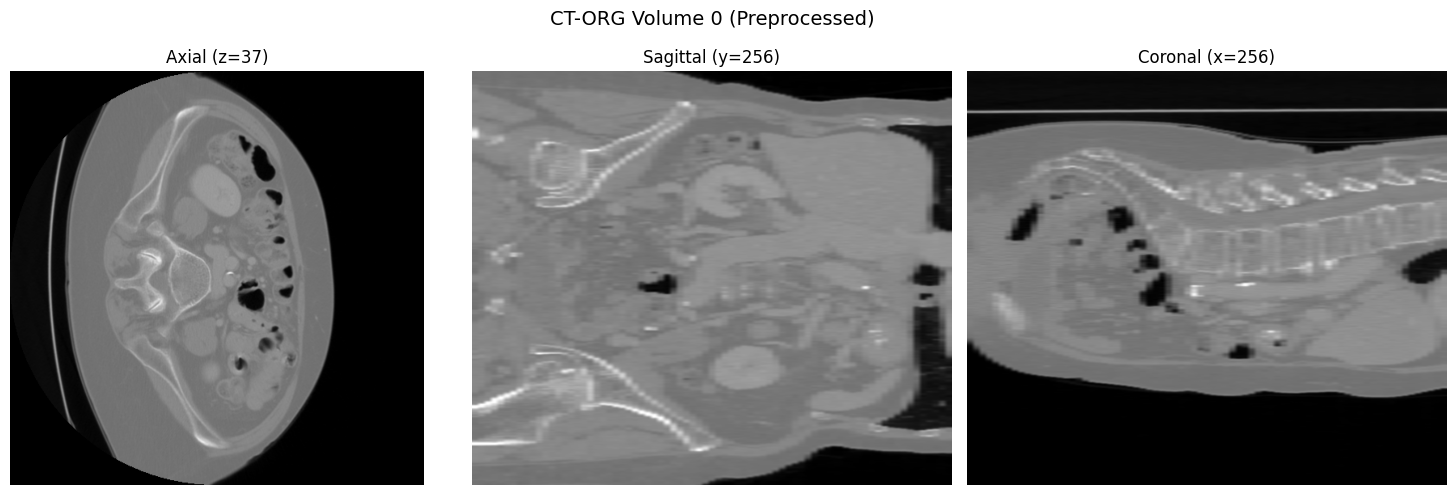

In [14]:
# Load and visualize a sample volume
import matplotlib.pyplot as plt

sample_case = available_cases[0]
volume, labels, metadata = loader.load_and_preprocess(sample_case)

print(f"\nSample volume (case {sample_case}):")
print(f"  Shape: {volume.shape}")
print(f"  Value range: [{volume.min():.3f}, {volume.max():.3f}]")
print(f"  Voxel size: {metadata['voxel_size']}")
if labels is not None:
    print(f"  Labels shape: {labels.shape}")
    print(f"  Unique labels: {np.unique(labels)}")

# Visualize axial, sagittal, coronal views
H, W, D = volume.shape
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(volume[:, :, D // 2], cmap='gray', vmin=0, vmax=1)
axes[0].set_title(f'Axial (z={D // 2})')
axes[0].axis('off')

axes[1].imshow(volume[:, W // 2, :], cmap='gray', vmin=0, vmax=1, aspect='auto')
axes[1].set_title(f'Sagittal (y={W // 2})')
axes[1].axis('off')

axes[2].imshow(volume[H // 2, :, :], cmap='gray', vmin=0, vmax=1, aspect='auto')
axes[2].set_title(f'Coronal (x={H // 2})')
axes[2].axis('off')

plt.suptitle(f'CT-ORG Volume {sample_case} (Preprocessed)', fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
# Demonstrate sparse slice simulation
from src.data.sparse_simulator import SparseSimulator

for R in config["data"]["sparse_ratios"]:
    simulator = SparseSimulator(sparse_ratio=R)
    sparse_data = simulator.simulate(volume)

    print(f"\n--- Sparse Ratio R={R} ---")
    print(f"  Observed slices: {len(sparse_data['observed_indices'])} "
          f"(out of {D})")
    print(f"  Target slices: {len(sparse_data['target_indices'])}")
    print(f"  Observed indices (first 10): {sparse_data['observed_indices'][:10]}")
    print(f"  Target indices (first 10): {sparse_data['target_indices'][:10]}")


--- Sparse Ratio R=2 ---
  Observed slices: 38 (out of 75)
  Target slices: 37
  Observed indices (first 10): [ 0  2  4  6  8 10 12 14 16 18]
  Target indices (first 10): [ 1  3  5  7  9 11 13 15 17 19]

--- Sparse Ratio R=3 ---
  Observed slices: 25 (out of 75)
  Target slices: 50
  Observed indices (first 10): [ 0  3  6  9 12 15 18 21 24 27]
  Target indices (first 10): [ 1  2  4  5  7  8 10 11 13 14]


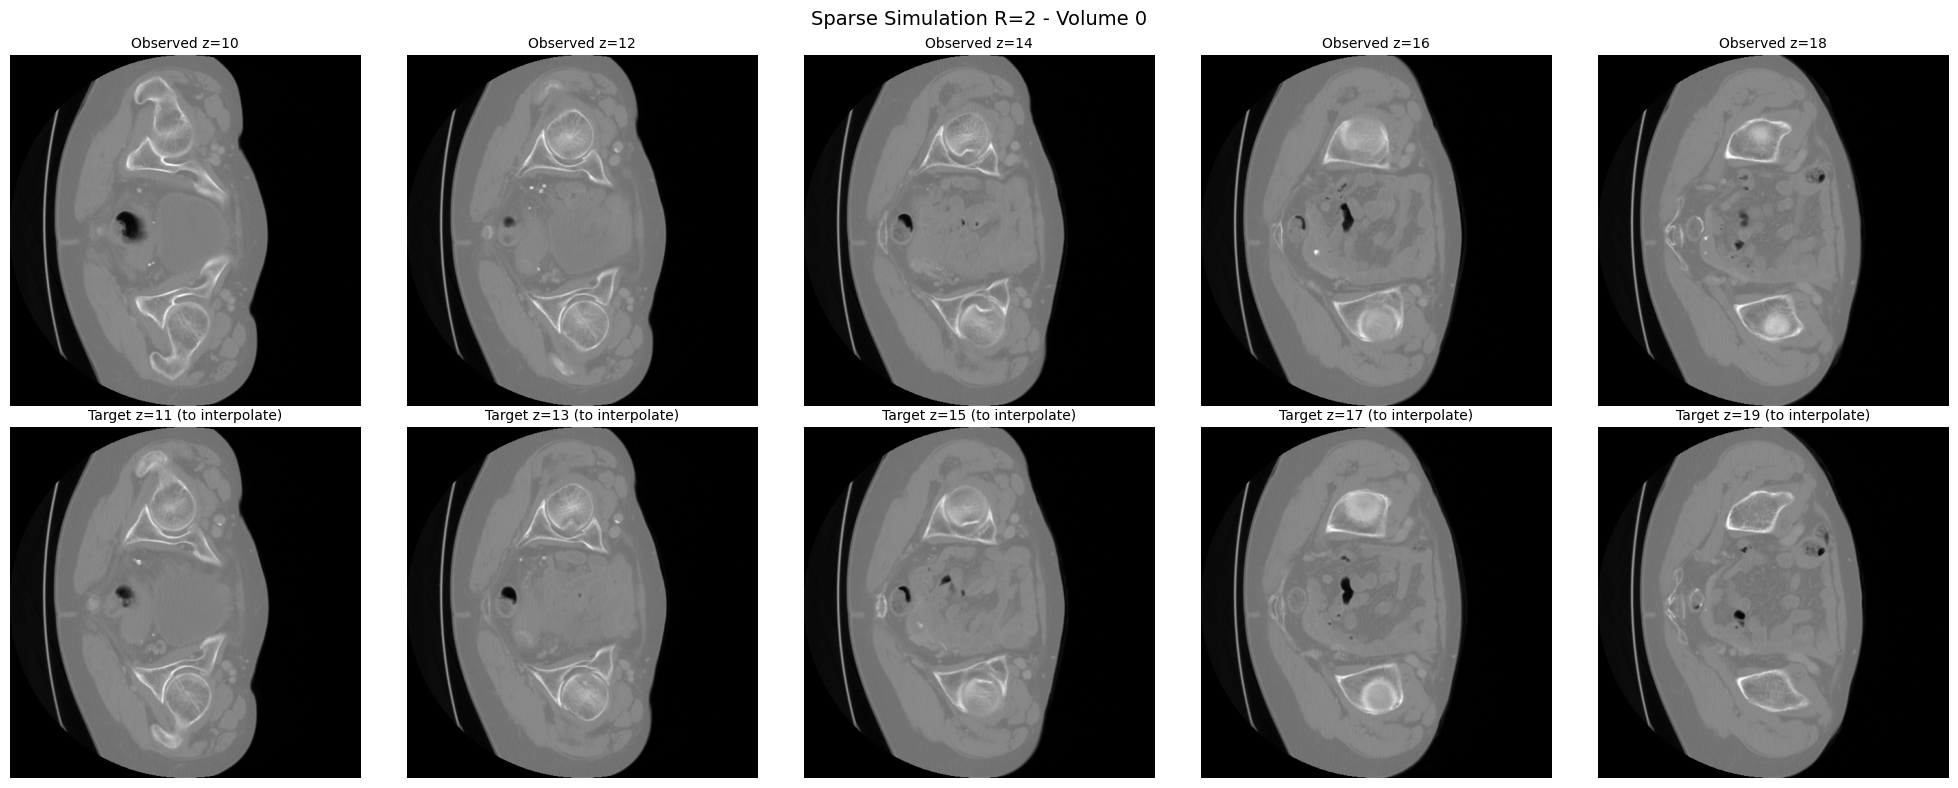


Data preparation complete! Ready for experiments.


In [16]:
# Visualize sparse simulation
R = 2
simulator = SparseSimulator(sparse_ratio=R)
sparse_data = simulator.simulate(volume)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Show observed slices (top row)
for i in range(5):
    z_idx = sparse_data['observed_indices'][i + 5]
    axes[0, i].imshow(volume[:, :, z_idx], cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'Observed z={z_idx}', fontsize=10)
    axes[0, i].axis('off')

# Show target slices (bottom row)
for i in range(5):
    z_idx = sparse_data['target_indices'][i + 5]
    axes[1, i].imshow(volume[:, :, z_idx], cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Target z={z_idx} (to interpolate)', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle(f'Sparse Simulation R={R} - Volume {sample_case}', fontsize=14)
plt.tight_layout()
plt.show()

print("\nData preparation complete! Ready for experiments.")